In [ ]:
import torch
from transformers import (
    BartForConditionalGeneration, BartTokenizer,
    T5ForConditionalGeneration, T5Tokenizer,
    PegasusForConditionalGeneration, PegasusTokenizer,
    pipeline
)

# Función para calcular métricas básicas
def calculate_metrics(original_text, summary):
    compression_ratio = len(summary.split()) / len(original_text.split())
    return {
        "compression_ratio": compression_ratio,
        "summary_length": len(summary.split())
    }

# Función para generar resumen con un modelo específico
def generate_summary(text, model, tokenizer, max_length=150, min_length=40):
    inputs = tokenizer(text, return_tensors="pt", max_length=1024, truncation=True)

    summary_ids = model.generate(
        inputs["input_ids"],
        max_length=max_length,
        min_length=min_length,
        num_beams=4,
        length_penalty=2.0,
        early_stopping=True
    )

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Texto de ejemplo para resumir
text_to_summarize = """
La inteligencia artificial (IA) ha experimentado avances significativos en los últimos años.
Los modelos de lenguaje de gran tamaño como GPT-4, Claude, y LLaMA han demostrado capacidades
impresionantes en tareas de generación de texto, comprensión de lenguaje natural y resolución de
problemas complejos. Estos modelos utilizan arquitecturas Transformer con miles de millones de
parámetros y han sido entrenados en vastos corpus de texto de internet. A pesar de sus capacidades,
también presentan limitaciones, como la tendencia a generar información incorrecta (alucinaciones),
sesgos inherentes a los datos de entrenamiento, y consumo intensivo de recursos computacionales.
La investigación actual se centra en mejorar estas limitaciones, desarrollar modelos más eficientes
y alinear mejor los sistemas de IA con valores humanos. El campo avanza rápidamente, con nuevas
arquitecturas y técnicas de entrenamiento que surgen constantemente.
"""

# Comparar varios modelos de summarization
def compare_summarization_models(text):
    models = {
        "BART": {
            "model_name": "facebook/bart-large-cnn",
            "model_class": BartForConditionalGeneration,
            "tokenizer_class": BartTokenizer
        },
        "T5": {
            "model_name": "t5-base",
            "model_class": T5ForConditionalGeneration,
            "tokenizer_class": T5Tokenizer
        },
        "Pegasus": {
            "model_name": "google/pegasus-xsum",
            "model_class": PegasusForConditionalGeneration,
            "tokenizer_class": PegasusTokenizer
        },
        "DistilBART": {
            "model_name": "sshleifer/distilbart-cnn-12-6",
            "pipeline": True
        }
    }

    results = {}

    for name, config in models.items():
        print(f"\nProcesando modelo: {name}")

        if config.get("pipeline", False):
            # Usar pipeline para modelos más ligeros
            summarizer = pipeline("summarization", model=config["model_name"])
            summary = summarizer(text, max_length=150, min_length=40, do_sample=False)[0]["summary_text"]
        else:
            # Cargar modelo y tokenizer
            tokenizer = config["tokenizer_class"].from_pretrained(config["model_name"])
            model = config["model_class"].from_pretrained(config["model_name"])

            # Generar resumen
            summary = generate_summary(text, model, tokenizer)

        # Calcular métricas
        metrics = calculate_metrics(text, summary)

        results[name] = {
            "summary": summary,
            "metrics": metrics
        }

        print(f"Resumen generado con {name}:")
        print(summary)
        print(f"Tasa de compresión: {metrics['compression_ratio']:.2f}")
        print(f"Longitud del resumen: {metrics['summary_length']} palabras")

    return results

# Ejecutar la comparación
if __name__ == "__main__":
    print("Comparando modelos de summarization...")
    results = compare_summarization_models(text_to_summarize)

    # Imprimir comparación final
    print("\n=== COMPARACIÓN FINAL ===")
    for name, result in results.items():
        print(f"\n{name}:")
        print(f"- Tasa de compresión: {result['metrics']['compression_ratio']:.2f}")
        print(f"- Longitud: {result['metrics']['summary_length']} palabras")

Comparando modelos de summarization...

Procesando modelo: BART
Resumen generado con BART:
GPT-4, Claude, and LLaMA han demostrado capacidades impresionantes. Estos modelos utilizan arquitecturas Transformer con miles de millones of parámetros. La investigación actual se centra en mejorar estas limitaciones.
Tasa de compresión: 0.21
Longitud del resumen: 28 palabras

Procesando modelo: T5
Resumen generado con T5:
.. La inteligencia artificial (IA) ha experimentado avances significativos en los ltimos aos. El campo avanza rápidamente, con nuevas arquitecturas y técnicas de entrenamiento.
Tasa de compresión: 0.18
Longitud del resumen: 24 palabras

Procesando modelo: Pegasus


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Resumen generado con Pegasus:
El campo de técnicas artificiales utilizan arquitecturas Transformer con miles de millones de parmetros y han sido entrenados en vastos corpus de texto de internet.
Tasa de compresión: 0.19
Longitud del resumen: 25 palabras

Procesando modelo: DistilBART


Device set to use cpu


Resumen generado con DistilBART:
 The world's most popular video game, "The Game of Thrones", has been turned into a reality TV show . It is the first time in a decade that the world has seen the world's best video games have been released .
Tasa de compresión: 0.31
Longitud del resumen: 41 palabras

=== COMPARACIÓN FINAL ===

BART:
- Tasa de compresión: 0.21
- Longitud: 28 palabras

T5:
- Tasa de compresión: 0.18
- Longitud: 24 palabras

Pegasus:
- Tasa de compresión: 0.19
- Longitud: 25 palabras

DistilBART:
- Tasa de compresión: 0.31
- Longitud: 41 palabras


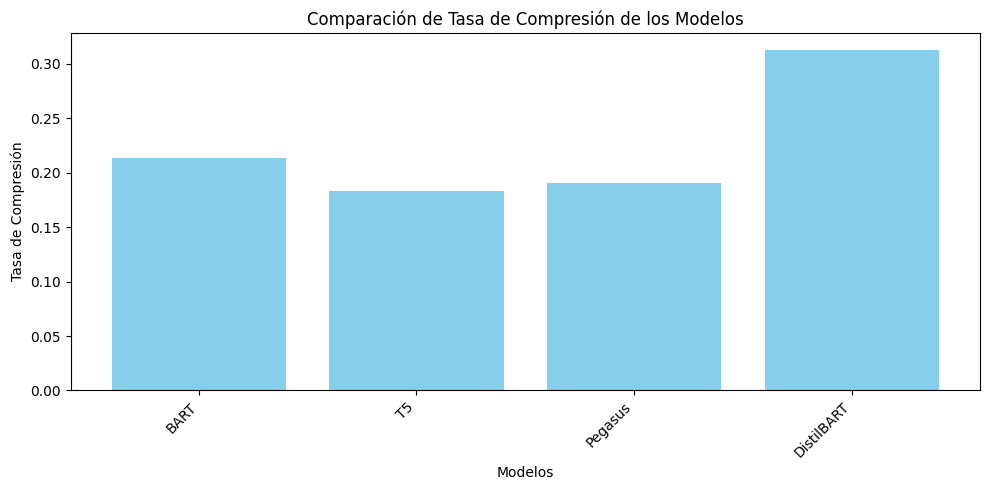

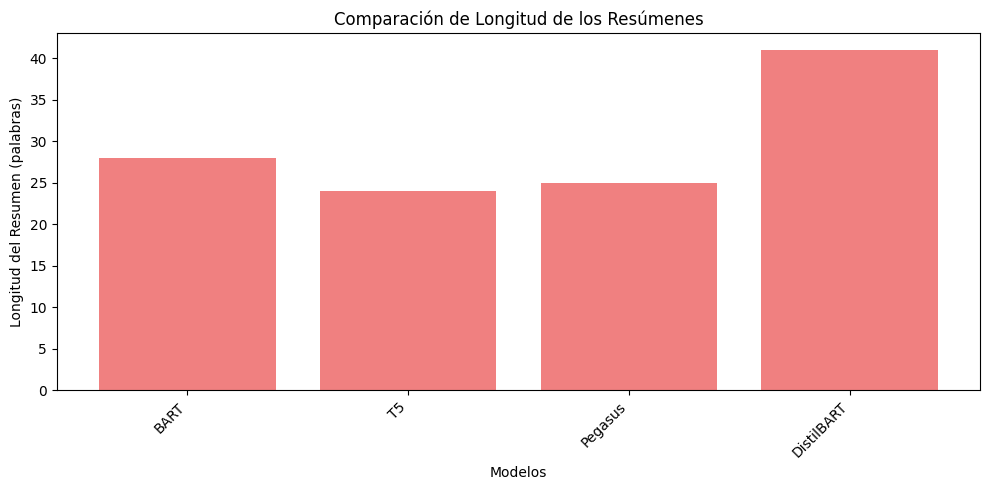

In [ ]:
# prompt: grafica los resultados

import matplotlib.pyplot as plt

# ... (código anterior) ...

if __name__ == "__main__":
    # ... (código anterior) ...

    # Preparar datos para la gráfica
    models = list(results.keys())
    compression_ratios = [result['metrics']['compression_ratio'] for result in results.values()]
    summary_lengths = [result['metrics']['summary_length'] for result in results.values()]

    # Crear la gráfica de barras para la tasa de compresión
    plt.figure(figsize=(10, 5))
    plt.bar(models, compression_ratios, color='skyblue')
    plt.xlabel("Modelos")
    plt.ylabel("Tasa de Compresión")
    plt.title("Comparación de Tasa de Compresión de los Modelos")
    plt.xticks(rotation=45, ha='right')  # Rotar etiquetas del eje x para mejor legibilidad
    plt.tight_layout()  # Ajustar el diseño para evitar que las etiquetas se superpongan
    plt.show()


    # Crear la gráfica de barras para la longitud del resumen
    plt.figure(figsize=(10, 5))
    plt.bar(models, summary_lengths, color='lightcoral')
    plt.xlabel("Modelos")
    plt.ylabel("Longitud del Resumen (palabras)")
    plt.title("Comparación de Longitud de los Resúmenes")
    plt.xticks(rotation=45, ha='right')  # Rotar etiquetas del eje x para mejor legibilidad
    plt.tight_layout()  # Ajustar el diseño para evitar que las etiquetas se superpongan
    plt.show()


**Métricas de evaluación**

In [ ]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=94c4e2f8aca50db054f9c8592c400c6bf5b5f6d12334ca82eef78e57345a5cf9
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:
!pip install nltk
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import torch
from transformers import (
    BartForConditionalGeneration, BartTokenizer,
    T5ForConditionalGeneration, T5Tokenizer,
    PegasusForConditionalGeneration, PegasusTokenizer
)
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import numpy as np
import pandas as pd
import nltk

# Descargar recursos necesarios de NLTK
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Función para generar resumen con un modelo específico
def generate_summary(text, model, tokenizer, max_length=150, min_length=40):
    inputs = tokenizer(text, return_tensors="pt", max_length=1024, truncation=True)

    summary_ids = model.generate(
        inputs["input_ids"],
        max_length=max_length,
        min_length=min_length,
        num_beams=4,
        length_penalty=2.0,
        early_stopping=True
    )

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Función para calcular métricas BLEU
def calculate_bleu(reference, hypothesis):
    # Tokenizar las oraciones
    reference_tokens = nltk.word_tokenize(reference.lower())
    hypothesis_tokens = nltk.word_tokenize(hypothesis.lower())

    # Aplicar suavizado para evitar puntuaciones de 0 cuando no hay coincidencias
    smoothie = SmoothingFunction().method1

    # Calcular BLEU para diferentes n-gramas
    bleu_1 = sentence_bleu([reference_tokens], hypothesis_tokens,
                          weights=(1, 0, 0, 0), smoothing_function=smoothie)
    bleu_2 = sentence_bleu([reference_tokens], hypothesis_tokens,
                          weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
    bleu_3 = sentence_bleu([reference_tokens], hypothesis_tokens,
                          weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
    bleu_4 = sentence_bleu([reference_tokens], hypothesis_tokens,
                          weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)

    return {
        'bleu-1': bleu_1,
        'bleu-2': bleu_2,
        'bleu-3': bleu_3,
        'bleu-4': bleu_4
    }

# Función para calcular métricas ROUGE
def calculate_rouge(reference, hypothesis):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, hypothesis)

    # Extraer valores F1-score
    return {
        'rouge-1': scores['rouge1'].fmeasure,
        'rouge-2': scores['rouge2'].fmeasure,
        'rouge-L': scores['rougeL'].fmeasure
    }

# Calcular todas las métricas
def calculate_all_metrics(reference, hypothesis):
    bleu_scores = calculate_bleu(reference, hypothesis)
    rouge_scores = calculate_rouge(reference, hypothesis)

    # Combinar resultados
    metrics = {**bleu_scores, **rouge_scores}
    return metrics

# Texto original y resumen de referencia
original_text = """
La inteligencia artificial (IA) ha experimentado avances significativos en los últimos años.
Los modelos de lenguaje de gran tamaño como GPT-4, Claude, y LLaMA han demostrado capacidades
impresionantes en tareas de generación de texto, comprensión de lenguaje natural y resolución de
problemas complejos. Estos modelos utilizan arquitecturas Transformer con miles de millones de
parámetros y han sido entrenados en vastos corpus de texto de internet. A pesar de sus capacidades,
también presentan limitaciones, como la tendencia a generar información incorrecta (alucinaciones),
sesgos inherentes a los datos de entrenamiento, y consumo intensivo de recursos computacionales.
La investigación actual se centra en mejorar estas limitaciones, desarrollar modelos más eficientes
y alinear mejor los sistemas de IA con valores humanos. El campo avanza rápidamente, con nuevas
arquitecturas y técnicas de entrenamiento que surgen constantemente.
"""

# Un resumen de referencia creado por humano (ejemplo)
reference_summary = """
La IA ha avanzado significativamente con modelos de lenguaje como GPT-4 que muestran impresionantes
capacidades en generación de texto y resolución de problemas. Estos modelos Transformer con miles
de millones de parámetros presentan limitaciones como alucinaciones, sesgos y alto consumo de recursos.
La investigación actual busca mejorar estas limitaciones, desarrollar modelos más eficientes y
alinear la IA con valores humanos.
"""

# Función principal para evaluar y comparar modelos
def evaluate_summarization_models(text, reference):
    models = {
        "BART": {
            "model_name": "facebook/bart-large-cnn",
            "model_class": BartForConditionalGeneration,
            "tokenizer_class": BartTokenizer
        },
        "T5": {
            "model_name": "t5-base",
            "model_class": T5ForConditionalGeneration,
            "tokenizer_class": T5Tokenizer
        },
        "Pegasus": {
            "model_name": "google/pegasus-xsum",
            "model_class": PegasusForConditionalGeneration,
            "tokenizer_class": PegasusTokenizer
        }
    }

    results = {}

    print("Evaluando modelos de summarization...")

    for name, config in models.items():
        print(f"\nProcesando modelo: {name}")

        # Cargar modelo y tokenizer
        tokenizer = config["tokenizer_class"].from_pretrained(config["model_name"])
        model = config["model_class"].from_pretrained(config["model_name"])

        # Generar resumen
        summary = generate_summary(text, model, tokenizer)

        # Calcular métricas
        metrics = calculate_all_metrics(reference, summary)
        compression_ratio = len(summary.split()) / len(text.split())

        results[name] = {
            "summary": summary,
            "metrics": metrics,
            "compression_ratio": compression_ratio,
            "summary_length": len(summary.split())
        }

        print(f"Resumen generado con {name}:")
        print(summary)
        print("\nMétricas:")
        for metric_name, value in metrics.items():
            print(f"- {metric_name}: {value:.4f}")

    return results

# Ejecutar evaluación
if __name__ == "__main__":
    results = evaluate_summarization_models(original_text, reference_summary)

    # Crear tabla comparativa
    metrics_data = {
        'Modelo': [],
        'BLEU-1': [],
        'BLEU-2': [],
        'BLEU-3': [],
        'BLEU-4': [],
        'ROUGE-1': [],
        'ROUGE-2': [],
        'ROUGE-L': [],
        'Tasa de compresión': [],
        'Longitud': []
    }

    for name, result in results.items():
        metrics_data['Modelo'].append(name)
        metrics_data['BLEU-1'].append(result['metrics']['bleu-1'])
        metrics_data['BLEU-2'].append(result['metrics']['bleu-2'])
        metrics_data['BLEU-3'].append(result['metrics']['bleu-3'])
        metrics_data['BLEU-4'].append(result['metrics']['bleu-4'])
        metrics_data['ROUGE-1'].append(result['metrics']['rouge-1'])
        metrics_data['ROUGE-2'].append(result['metrics']['rouge-2'])
        metrics_data['ROUGE-L'].append(result['metrics']['rouge-L'])
        metrics_data['Tasa de compresión'].append(result['compression_ratio'])
        metrics_data['Longitud'].append(result['summary_length'])

    # Crear DataFrame y mostrar resultados
    df = pd.DataFrame(metrics_data)
    print("\n=== COMPARACIÓN DE MÉTRICAS ===")
    print(df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

    # Mostrar resúmenes generados
    print("\n=== RESÚMENES GENERADOS ===")
    for name, result in results.items():
        print(f"\n{name}:")
        print(result['summary'])

    print("\n=== RESUMEN DE REFERENCIA ===")
    print(reference_summary)

Evaluando modelos de summarization...

Procesando modelo: BART
Resumen generado con BART:
GPT-4, Claude, and LLaMA han demostrado capacidades impresionantes. Estos modelos utilizan arquitecturas Transformer con miles de millones of parámetros. La investigación actual se centra en mejorar estas limitaciones.

Métricas:
- bleu-1: 0.2643
- bleu-2: 0.1856
- bleu-3: 0.1448
- bleu-4: 0.1028
- rouge-1: 0.4330
- rouge-2: 0.2526
- rouge-L: 0.3918

Procesando modelo: T5
Resumen generado con T5:
.. La inteligencia artificial (IA) ha experimentado avances significativos en los ltimos aos. El campo avanza rápidamente, con nuevas arquitecturas y técnicas de entrenamiento.

Métricas:
- bleu-1: 0.0997
- bleu-2: 0.0101
- bleu-3: 0.0050
- bleu-4: 0.0033
- rouge-1: 0.1538
- rouge-2: 0.0225
- rouge-L: 0.1538

Procesando modelo: Pegasus


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Resumen generado con Pegasus:
El campo de técnicas artificiales utilizan arquitecturas Transformer con miles de millones de parmetros y han sido entrenados en vastos corpus de texto de internet.

Métricas:
- bleu-1: 0.1116
- bleu-2: 0.0773
- bleu-3: 0.0614
- bleu-4: 0.0504
- rouge-1: 0.2609
- rouge-2: 0.1333
- rouge-L: 0.1957

=== COMPARACIÓN DE MÉTRICAS ===
 Modelo  BLEU-1  BLEU-2  BLEU-3  BLEU-4  ROUGE-1  ROUGE-2  ROUGE-L  Tasa de compresión  Longitud
   BART  0.2643  0.1856  0.1448  0.1028   0.4330   0.2526   0.3918              0.2137        28
     T5  0.0997  0.0101  0.0050  0.0033   0.1538   0.0225   0.1538              0.1832        24
Pegasus  0.1116  0.0773  0.0614  0.0504   0.2609   0.1333   0.1957              0.1908        25

=== RESÚMENES GENERADOS ===

BART:
GPT-4, Claude, and LLaMA han demostrado capacidades impresionantes. Estos modelos utilizan arquitecturas Transformer con miles de millones of parámetros. La investigación actual se centra en mejorar estas limitacion

Evaluando modelos de summarization...

Procesando modelo: BART
Resumen generado con BART:
GPT-4, Claude, and LLaMA han demostrado capacidades impresionantes. Estos modelos utilizan arquitecturas Transformer con miles de millones of parámetros. La investigación actual se centra en mejorar estas limitaciones.

Métricas:
- bleu-1: 0.2643
- bleu-2: 0.1856
- bleu-3: 0.1448
- bleu-4: 0.1028
- rouge-1: 0.4330
- rouge-2: 0.2526
- rouge-L: 0.3918

Procesando modelo: T5
Resumen generado con T5:
.. La inteligencia artificial (IA) ha experimentado avances significativos en los ltimos aos. El campo avanza rápidamente, con nuevas arquitecturas y técnicas de entrenamiento.

Métricas:
- bleu-1: 0.0997
- bleu-2: 0.0101
- bleu-3: 0.0050
- bleu-4: 0.0033
- rouge-1: 0.1538
- rouge-2: 0.0225
- rouge-L: 0.1538

Procesando modelo: Pegasus


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Resumen generado con Pegasus:
El campo de técnicas artificiales utilizan arquitecturas Transformer con miles de millones de parmetros y han sido entrenados en vastos corpus de texto de internet.

Métricas:
- bleu-1: 0.1116
- bleu-2: 0.0773
- bleu-3: 0.0614
- bleu-4: 0.0504
- rouge-1: 0.2609
- rouge-2: 0.1333
- rouge-L: 0.1957

=== COMPARACIÓN DE MÉTRICAS ===
 Modelo  BLEU-1  BLEU-2  BLEU-3  BLEU-4  ROUGE-1  ROUGE-2  ROUGE-L  Tasa de compresión  Longitud
   BART  0.2643  0.1856  0.1448  0.1028   0.4330   0.2526   0.3918              0.2137        28
     T5  0.0997  0.0101  0.0050  0.0033   0.1538   0.0225   0.1538              0.1832        24
Pegasus  0.1116  0.0773  0.0614  0.0504   0.2609   0.1333   0.1957              0.1908        25


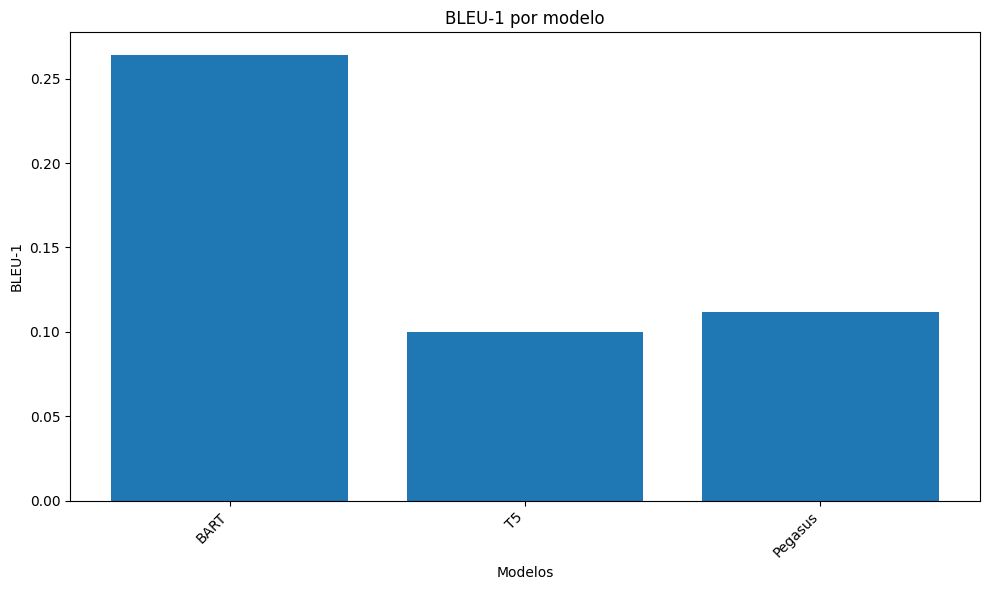

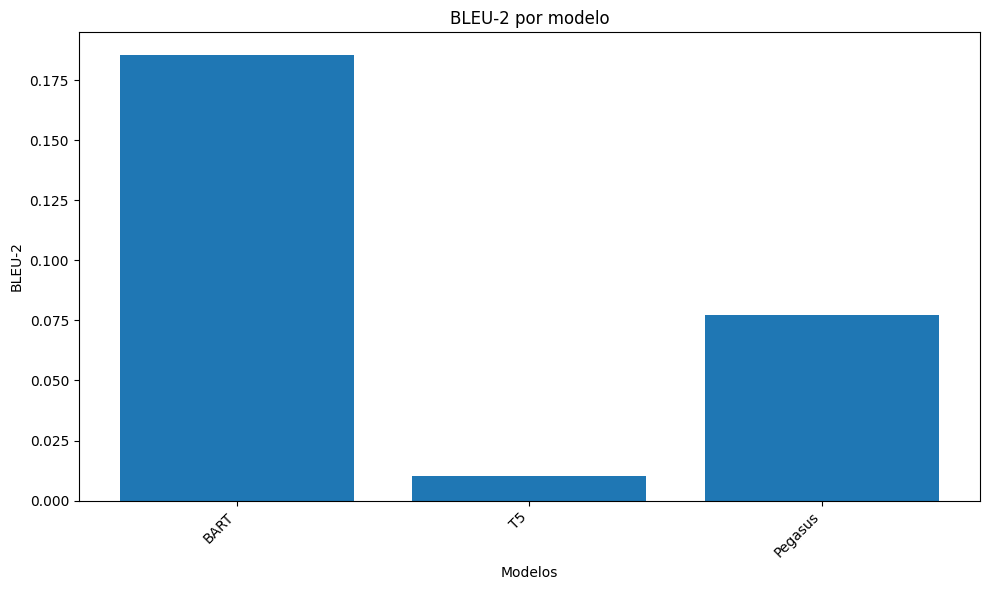

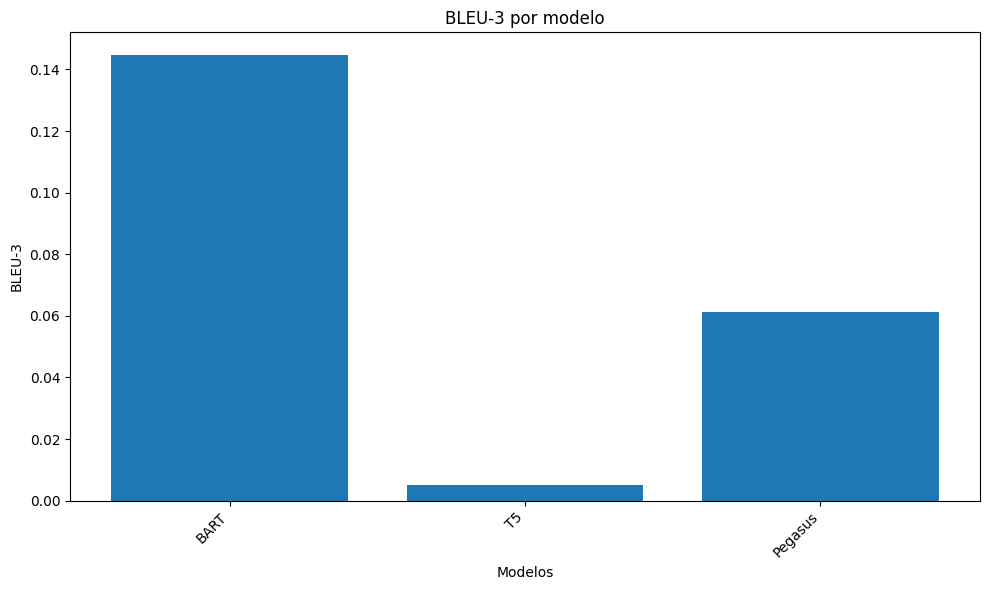

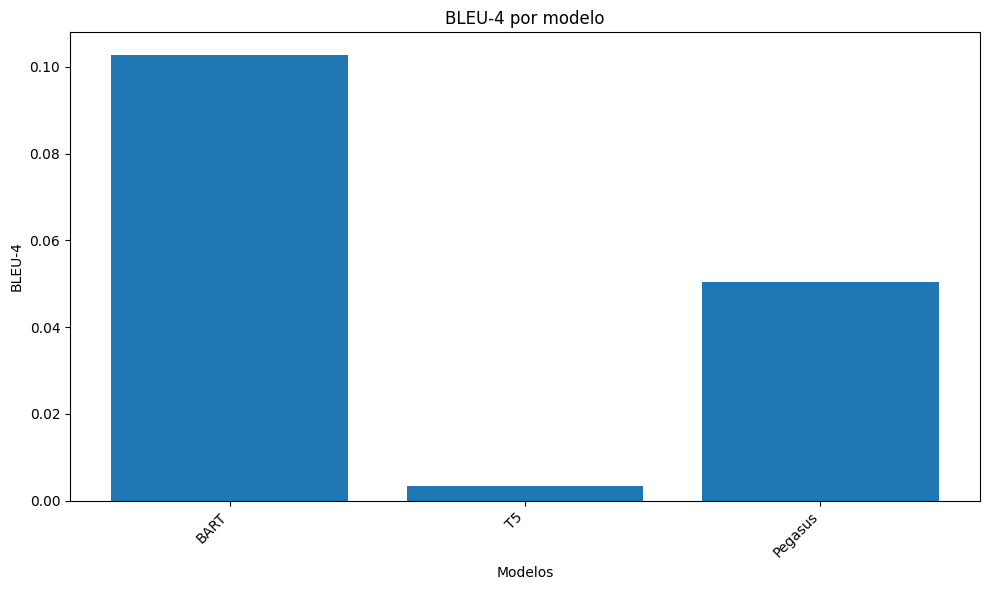

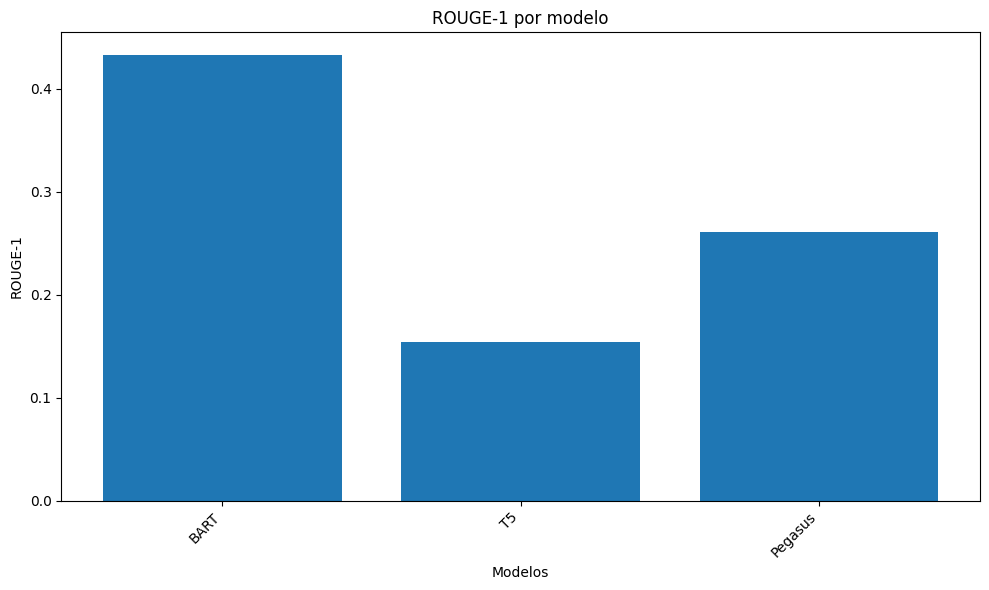

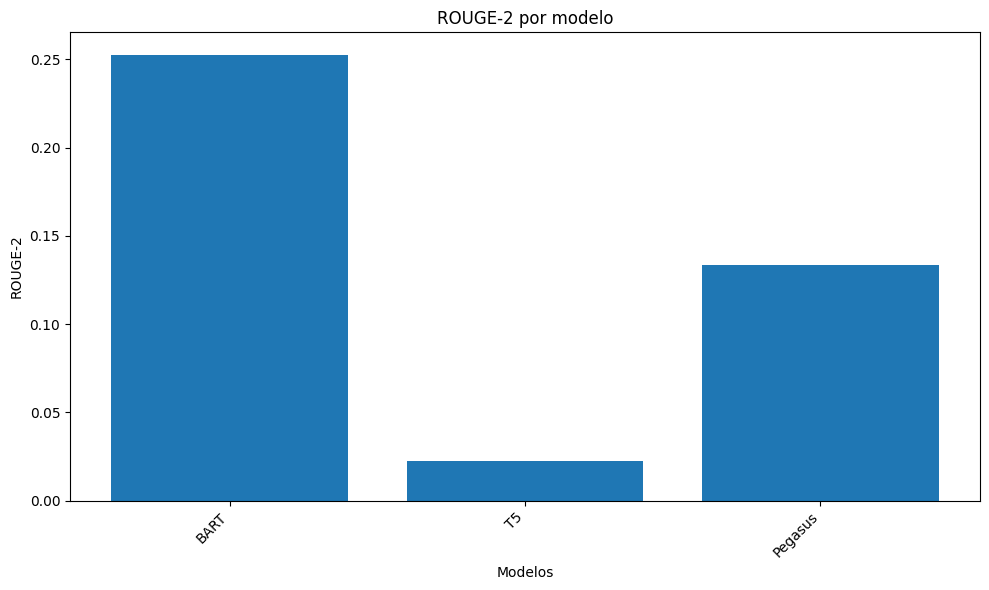

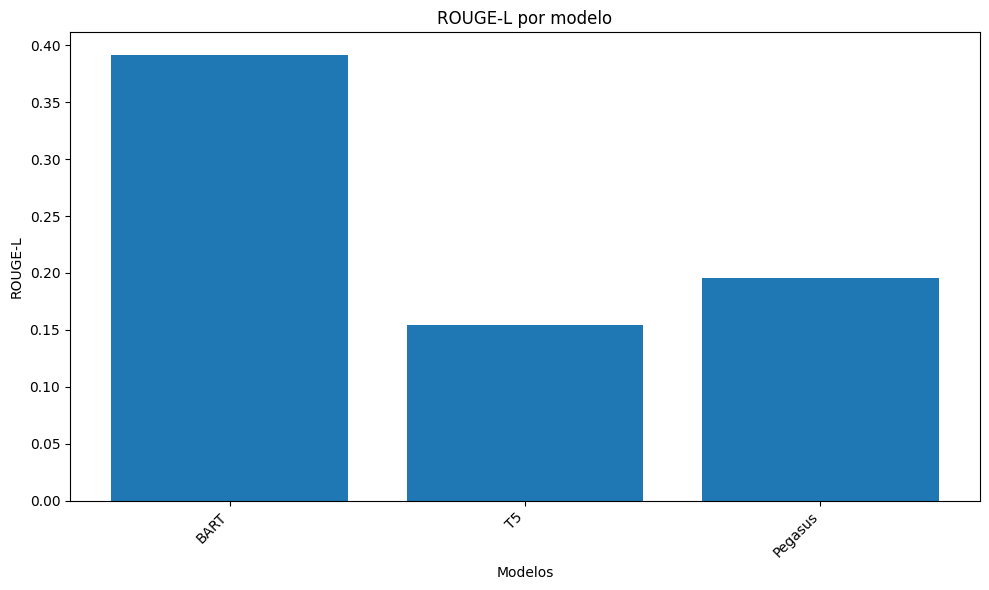

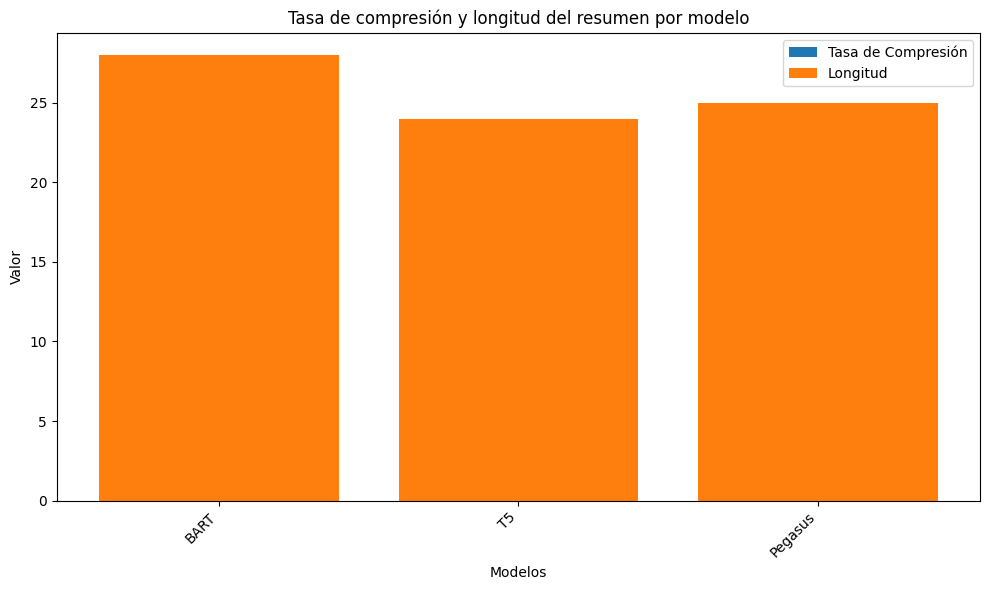


=== RESÚMENES GENERADOS ===

BART:
GPT-4, Claude, and LLaMA han demostrado capacidades impresionantes. Estos modelos utilizan arquitecturas Transformer con miles de millones of parámetros. La investigación actual se centra en mejorar estas limitaciones.

T5:
.. La inteligencia artificial (IA) ha experimentado avances significativos en los ltimos aos. El campo avanza rápidamente, con nuevas arquitecturas y técnicas de entrenamiento.

Pegasus:
El campo de técnicas artificiales utilizan arquitecturas Transformer con miles de millones de parmetros y han sido entrenados en vastos corpus de texto de internet.

=== RESUMEN DE REFERENCIA ===

La IA ha avanzado significativamente con modelos de lenguaje como GPT-4 que muestran impresionantes 
capacidades en generación de texto y resolución de problemas. Estos modelos Transformer con miles 
de millones de parámetros presentan limitaciones como alucinaciones, sesgos y alto consumo de recursos. 
La investigación actual busca mejorar estas limitac

In [ ]:
# prompt: grafica las métricas

import pandas as pd
import matplotlib.pyplot as plt

# Ejecutar evaluación
if __name__ == "__main__":
    results = evaluate_summarization_models(original_text, reference_summary)

    # Crear tabla comparativa
    metrics_data = {
        'Modelo': [],
        'BLEU-1': [],
        'BLEU-2': [],
        'BLEU-3': [],
        'BLEU-4': [],
        'ROUGE-1': [],
        'ROUGE-2': [],
        'ROUGE-L': [],
        'Tasa de compresión': [],
        'Longitud': []
    }

    for name, result in results.items():
        metrics_data['Modelo'].append(name)
        metrics_data['BLEU-1'].append(result['metrics']['bleu-1'])
        metrics_data['BLEU-2'].append(result['metrics']['bleu-2'])
        metrics_data['BLEU-3'].append(result['metrics']['bleu-3'])
        metrics_data['BLEU-4'].append(result['metrics']['bleu-4'])
        metrics_data['ROUGE-1'].append(result['metrics']['rouge-1'])
        metrics_data['ROUGE-2'].append(result['metrics']['rouge-2'])
        metrics_data['ROUGE-L'].append(result['metrics']['rouge-L'])
        metrics_data['Tasa de compresión'].append(result['compression_ratio'])
        metrics_data['Longitud'].append(result['summary_length'])

    # Crear DataFrame y mostrar resultados
    df = pd.DataFrame(metrics_data)  # This line and subsequent lines should be at the same indentation level as the if statement
    print("\n=== COMPARACIÓN DE MÉTRICAS ===")
    print(df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

    # Gráfica de barras para las métricas
    metrics_to_plot = ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L']

    for metric in metrics_to_plot:
        plt.figure(figsize=(10, 6))
        plt.bar(df['Modelo'], df[metric])
        plt.xlabel('Modelos')
        plt.ylabel(metric)
        plt.title(f'{metric} por modelo')
        plt.xticks(rotation=45, ha='right')  # Rotar etiquetas del eje x para mejor legibilidad
        plt.tight_layout() # Ajusta los elementos para evitar que las etiquetas se superpongan
        plt.show()

    # Gráfica de barras para la tasa de compresión y longitud del resumen
    plt.figure(figsize=(10, 6))
    plt.bar(df['Modelo'], df['Tasa de compresión'], label='Tasa de Compresión')
    plt.bar(df['Modelo'], df['Longitud'], label='Longitud')
    plt.xlabel('Modelos')
    plt.ylabel('Valor')
    plt.title('Tasa de compresión y longitud del resumen por modelo')
    plt.xticks(rotation=45, ha='right')  # Rotar etiquetas del eje x para mejor legibilidad
    plt.legend() # Mostrar la leyenda
    plt.tight_layout() # Ajusta los elementos para evitar que las etiquetas se superpongan
    plt.show()

    # Mostrar resúmenes generados
    print("\n=== RESÚMENES GENERADOS ===")
    for name, result in results.items():
        print(f"\n{name}:")
        print(result['summary'])

    print("\n=== RESUMEN DE REFERENCIA ===")
    print(reference_summary) # Added print statement to display reference_summary